<a href="https://colab.research.google.com/github/anoukB/tutorial_from_tracking_to_posture_dynamics/blob/main/Part_1_PCA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eigenmaggots

Note: This notebook is a nearly identical adaptation of the notebook from BingKan Xue, PHZ4710 - Introduction to Biological Physics, University of Florida about Eigenworms. The quotes are directly from it.  


## Imports and installations

This first section makes sure you have all the necessary functions to run this tutorial smoothly.

In [ ]:
#Install necessary environment for display of videos
!pip install -U kora
from kora.drive import upload_public
from IPython.display import HTML

#Other imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.6 MB/s eta 0:00:00


In [ ]:
#Make a function to display pictures easily
def display_picture(url):
  im = plt.imread(url)

  fig, axs = plt.subplots(ncols=1, nrows=1)
  axs.imshow(im, cmap='gray')
  axs.set_axis_off()

In [ ]:
#Clone the repository with all files, images and videos. This will result in a folder called cloned-repo
!git clone -l -s https://github.com/anoukB/tutorial_from_tracking_to_posture_dynamics cloned-repo
%cd cloned-repo
!ls  #Listo of all elements in the repo

Cloning into 'cloned-repo'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 26 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (26/26), 13.36 MiB | 17.65 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/cloned-repo
clustering_methods.py		      README.md
delay_embedding_1D.py		      stats.py
file_angles_larva.csv		      vid_intro_state_space_Sugihara.mp4
img_angles_calculation.png	      vid_larva_experiment_Irina_Korshok.mp4
img_measurement_matrix.png	      vid_phase_space_pendulum_Ghrist_Math.mp4
img_trajectory_matrix.png	      vid_Reconstructed_data.mp4
img_transition_matrix_schematics.png  vid_Takens_thm_Sugihara.mp4
img_umap_celegans_costa.png	      vid_tracked_larva_angles.mp4
operator_calculations.py	      vid_tracked_larva_segments.mp4


*** STOP HERE :)***

You need to set the directory for all the files that will be used in the tutorial. The folders from GitHub have been imported in your version of the tutorial, so you need to make sure this is correct. The most likely directory would be the one in the example, but in case anything is different in your case, we will let you set it up.

In [ ]:
#Example:
#directory = '/content/cloned-repo/'

directory =

## Introduction

In this first notebook of the series, we start our analysis by using a dimensionality reduction method in posture space.

"As one can imagine, behavior can be highly complex. In some animals, biologists have classified behavior by stereotypical postures or movements that they have defined based on experience. Recent technology, such as high-resolution and high-speed digital camera, has allowed us to take a more quantitative approach by collecting data on behavior. However, the data will most likely be high dimensional, as they may represent the color of each pixel, or the position of each body part, etc. Our goal is to see if we can simplify such high-dimensional representation to a much lower dimensional description, and perhaps these "principal" dimensions would match the stereotypical behaviors that were found "manually". Thus, we look for an automated and unbiased way of reducing the dimensionality of data to help us extract the basic modes of behavior."

The dataset we will use in this notebook and throughout the series is from Irina Korshok's experiment (Okinawa Institute of Science and Technology), where a  single Drosophila larva is freely crawling around in a foodless petri dish and recorded at 5 frames per second. Here follows a short example video of the recording. We will focus our investigation on the curvature of the larva for this tutorial, and exclude the peristaltic movement for now.



<div align="center">
<video src="short_video_real_experiment.mp4" align="middle" width="500" controls>  </video>
</div>


In [ ]:
#Video of the experiment
url = upload_public(directory + 'vid_larva_experiment_Irina_Korshok.mp4')

HTML(f"""<video src={url} width=500 controls/>""")




Even though the image is made of thousands of pixels, it seems obvious that there are not all instrumental in describing the larva's posture. How much information is enough? The first thing to notice is that the larva is made of individual segments (12) which are repeated functional units. The segments are great natural candidates to describe the larva's posture. In this experiment, the position of individual segments on both sides of the body are tracked using the SLEAP software. The tubular shape of the larva also allows us to draw a curve in the middle (midline), reducing the number of points by two. We then follow the positions of the 12 segments along the midline. The tracked data points look like the following.


In [ ]:
#Video of the segments position extracted from the experiment
url = upload_public(directory + 'vid_tracked_larva_segments.mp4')
HTML(f"""<video src={url} width=500 controls/>""")



Since the shape of the midline is invariant to translation or rotation, we can use the relative positions of each frames instead of their absolute coordinates.This means that instead of the (x,y) coordinates, we can directly calculate the angles of each segment relative to the horizontal line, as shown in the following picture.


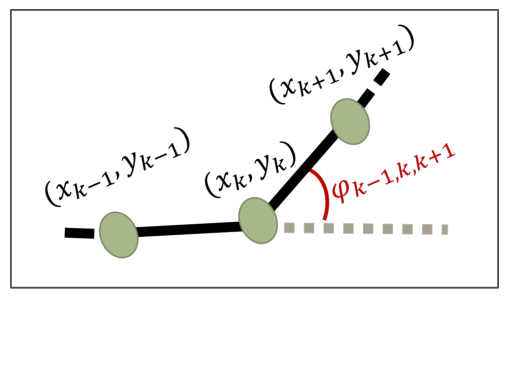

In [ ]:
display_picture(directory + 'img_angles_calculation.png')


To extract angles, all frames were first centered on top of each other. The D = 11 angles relative to the horizontal line were calculated and an overall rotation mode was removed by subtracting $\Sigma \theta_i/ D $ from each angle.

The dataset then contains angles exclusively, peristalsis is removed. The tracked angles data then look like the following:

<div align="center">
<video src="tracked_angles_only.mp4" align="middle" controls>  </video>
</div>



In [ ]:
#Video of the extracted angles
url = upload_public(directory + 'vid_tracked_larva_angles.mp4')
HTML(f"""<video src={url} width=500 controls/>""")

We now have a 11-dimensional dataset to descrive the larva's curvature. With this analysis, we will see how much more we can reduce that space.

## Principal Component Analysis (PCA)

We have 2993 frames, each with a 11-D vector of angles. We first load the data.

In [ ]:
# Load the file with angles from the proper directory
dir_file_storage = directory  #Choose your directory if using your own data
filename =  "file_angles_larva.csv"  #Filename
angles = np.loadtxt(dir_file_storage + filename , delimiter = ",")

### Covariance matrix

"We can think of each data point as a point in a $D$-dimensional space, and we have $N$ such points in that space. The idea of dimensionality reduction is that maybe these points lie on a lower dimensional subspace, like a 2d plane in a 3d space. In order to find such a subspace, we need to see how much the points vary in each direction. For example, if all points lie on a plane, then there will be variations parallel to the plane but no variation in the perpendicular direction. To find such major directions of variation, we will calculate the covariance matrix of these points.

Let the data be denoted by $X_{ni}$, where $n = 1, \cdots, N$ are the indices of the data points and $i = 1, \cdots, D$ are the indices of the components. The covariance matrix is given by:
\begin{equation}
C_{ij} = \frac{1}{N} \sum_{n=1}^{N} (X_{ni} - \bar{X}_i) (X_{nj} - \bar{X}_j)
\end{equation}
where $\bar{X}_i$ is the mean values of all data points given by:
\begin{equation}
\bar{X}_i = \frac{1}{N} \sum_{n=1}^{N} X_{ni}
\end{equation}
The covariance matrix is a $(D \times D)$ matrix, whose diagonal elements are the variance of the data points along each axis, and the off-diagonal elements are the covariance between two components. We can calculate the covariance matrix as follows."

In [ ]:
N = angles.shape[0] # number of data points
x_mean = np.mean(angles,axis=0)  # mean over data points
x_cent = angles - x_mean  # centered data
cov = np.dot(x_cent.T, x_cent) / N  # covariance matrix

plt.figure()
plt.imshow(cov)
plt.colorbar()
plt.show()

"There is clear structure in the covariance matrix, which suggests that the data points have larger variation in certain directions than others. However, the largest variations may not be as simple as being along some basis axes of the space. Rather, we have the freedom to rotate the axes and find the directions of most variation. This can be done by finding the eigenvectors of the covariance matrix that have the largest eigenvalues. We can calculate the eigenvalues and eigenvectors using the numpy.linalg.eig function. (Note that, because the covariance matrix is real and symmetric, all eigenvalues and eigenvectors are real. This allows us to use the eigh function instead.)
"

Let us interpret this covariance matrix.
In a covariance matrix, the diagonal terms represent the variance of the measurements. A large variance indicates an interesting structure along the axis of that measurement. Here, we note that the highest diagonal terms are at the larva's head, and a bit at its tail. It makes sense since the larva mainly explores its environment with its head.
Off-diagonal terms present the covariance between measurements. Non-zero off-diagonal terms indicate a redundancy in the measurements (they indirectly measure the same thing). A zero covariance means that the measurements are independent. We also see non-zero off-diagonal terms around the head and tail, which should not surprise us as close segments have more chances of redundancy. There is no covariance between head and tail:  they are independent measurements.

### Eigenvalues of the covariance matrix

In [ ]:
w, v = np.linalg.eigh(cov)  # find eigenvalues and eigenvectors of a real symmetric matrix
sort = np.argsort(w)[::-1]  # sort eigenvalues from largest to smallest
w = w[sort]
v = v[:, sort]  # sort eigenvectors accordingly

plt.figure()
plt.plot(w, 'o-')
plt.xlabel('eigenmode')
plt.ylabel('eigenvalue')
plt.show()



When we plot the sorted eigenvalues, we note that their values drop rapidly after the first few modes. Each of the eigenvalue is associated to an eigenvector. The eigenvectors associated to the highest eigenvalues are what we will call "Principal Components". To decide how many principal components we keep, we can calculate exactly which eigenvalue accounts for how much of the total variance in the dataset.

In [ ]:
w = w / np.sum(w)  # normalized eigenvalues = variance along each principal component
wsum = np.cumsum(w)  # cumulative sum of normalized eigenvalues = variance captured


plt.figure(figsize=(5, 5))
plt.plot(np.arange(1, 9), wsum[:8], 'o-')
plt.ylim(0, 1)
plt.xticks(np.arange(1, 9))
plt.xlabel('# principal components', fontsize=16)
plt.ylabel('cumulative variance', fontsize=16)
plt.show()

From this plot, we see that over 96% of the variance is explained by the first four components, and over 80% just by the first one. This prompts us to keep only four in this case, but we could decide to keep more if we wanted even more precision. We then reduced our posture space to 4 dimensions. We can plot the principal components to see what these dimensions look like.

### Eigenvectors of the covariance matrix (principal components)

In [ ]:
K = 4  # Choose the number of principal components you want
PC = v[:, :K]  # eigenvectors for these PCs; each column is one PC

fig, ax = plt.subplots(1, K, figsize=(5 * K, 4))

for i in range(K):
    ax[i].plot(PC[:, i])
    ax[i].set_title(f'PC{i + 1}')
plt.show()


These vectors are the 11 consecutive angles associated to the 11 segments of the larva. We can use those as new basis vectors to decompose any shape of the larva into four components. In other words, any shape of the larva could be described as a linear combination of these "eigenmaggots".

To visualize the shape of these eigenworms, we need to convert from angles of consecutive segments back to positions of the endpoints. This is done by the following function.


In [ ]:
def angle2pos(angles):
    """
    convert from angles of consecutive segments of unit length to positions of their endpoints.
    inputs:
    angles: 1-d array, angles of consecutive segments.
    outputs:
    pos: 2-d array, each row is (x,y) coordinates of an endpoint, centered at zeros.
    """
    dx = np.cos(angles)
    dy = np.sin(angles)
    xsum = np.cumsum(dx)
    ysum = np.cumsum(dy)
    pos = np.zeros((angles.shape[0]+1, 2))
    pos[1:,0] = xsum
    pos[1:,1] = ysum
    mean = np.mean(pos, axis=0)
    pos = pos - mean
    return pos

We can now plot the eigenmaggots in position space.

In [ ]:
pos_all = []
for i in range(K):
    pos = angle2pos(PC[:,i])    # convert PC to positions
    pos_all.append(pos)

fig, ax = plt.subplots(1,K, figsize=(5*K,4))
for i in range(K):
    pos = pos_all[i]
    ax[i].plot(pos[:,0], pos[:,1], '.-')
    ax[i].set_aspect('equal')
    ax[i].axis('off')
plt.show()

The ultimate test of our dimensionality reduction is to see if we can recover the original shapes of the larva using only these principal components. In other words, we will try to reconstruct the data from only the projections onto the principal components. The projections are given by:
\begin{equation}
Y_{nk} = \sum_{i} X_{ni} v_{ik}
\end{equation}
where `v` is the 2-d array returned by the `eigh()` function, each column of which is an eigenvector. We only need to calculate the first few components, $k = 1, \cdots, K$. The reconstructed data are given by:
\begin{equation}
\hat{X}_{ni} = \sum_{k=1}^{K} Y_{nk} v_{ik} = \sum_{k=1}^{K} Y_{nk} \big( v^\top \big)_{ki}
\end{equation}

### Data reconstruction

In [ ]:
# The first step is to reconstruct a time series from the projected data

x_project = np.dot(x_cent, PC)  # project (centered) data onto principal components
x_reconstruct = np.dot(x_project, PC.T) + x_mean  # reconstruct data from the projections

In [ ]:
pos_original = angle2pos(angles[0,:])    # original data from one frame
pos_reconstruct = angle2pos(x_reconstruct[0,:])    # reconstructed data

plt.figure(figsize=(4,4))
plt.plot(pos_original[:,0], pos_original[:,1], '.-', label='original')
plt.plot(pos_reconstruct[:,0], pos_reconstruct[:,1], '.-', label='reconstructed')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend()
plt.axis('off')
plt.show()

"Our reconstruction is very faithful to the original shape. There could be small discrepancies in some shapes due to our ignoring the "higher orders" in the decomposition. Nevertheless, the reduced description is much more concise (and space-saving and fast-to-process on computers), and hopefully accurate enough for further studies. " Finally, we can make a video of our data to verify how accurate our reconstruction looks.

In [ ]:
#Make an animation that superposes the raw data and the reconstructed data
plt.rcParams["animation.html"] = "jshtml"
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.axis('off')
p0, = ax.plot([], [], '.')
p1, = ax.plot([], [], '.')

def animate(t):
    pos_original = angle2pos(angles[t,:]) #original data
    pos_reconstruct = angle2pos(x_reconstruct[t, :]) # reconstructed data from the principal components
    p0.set_data(pos_original[:,0], pos_original[:,1])
    p1.set_data(pos_reconstruct[:, 0], pos_reconstruct[:, 1])
    return

mov = anim.FuncAnimation(fig, animate, frames=range(0, angles.shape[0]), interval=250)
writervideo = anim.FFMpegWriter(fps=5) #Insert here the correst fps for your data
#mov.save(directory + "Reconstructed_data" + ".mp4", writer = writervideo)
plt.show()
plt.close()

In [ ]:
# Visualize the video
mov

Finally, we load the time series projected onto the four principal components into a file, which we will use in the next parts of our analysis.
***Add the directory you want to store you file in. ***

In [ ]:
filename = "principal_components_time_series_larva" # Insert a filename here
dir_file_storage = directory #Add your directory here
file = open(dir_file_storage + filename + ".csv", "w")
np.savetxt(file, x_project, delimiter=",")
file.close()

NB: PCA is fundamentally a linear technique. If posture follows very complicated non-linear manifolds, there is a chance that PCA might not be the correct dimensionality-reduction technique for your dataset.